In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
counseldf = pd.read_csv('/content/drive/MyDrive/NLP/J component/counselchat-data.csv')

In [4]:
print(counseldf.columns)

Index(['questionID', 'questionTitle', 'questionText', 'questionUrl', 'topics',
       'therapistName', 'therapistUrl', 'answerText', 'upvotes'],
      dtype='object')


In [5]:
counseldf.head()


,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,My wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>What you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"I'm planning to have baby, so I have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi. Good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"I have secrets in my mind, and I don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>It sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,I am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi there. It's great you are able to realiz...,0
4,556ba115c969ba5861709de6,Can I control anxiety without medication?,I had a head injury a few years ago and my min...,https://counselchat.com/questions/can-i-contro...,Anxiety,Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>You didn't say what or how many medications...,0


As the dataset contains some columns with personal information about the therapist, those columns are removed. Moreover, for the purposes of this project the only relevant columns are 'questionText' and 'topics'. Hence all other columns except those are removed before further processing.

In [6]:
counseldf.drop(['questionID', 'questionTitle', 'questionUrl', 'therapistName', 'therapistUrl','answerText', 'upvotes'], axis = 1, inplace=True)

In [7]:
counseldf.head()

,questionText,topics
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...","Substance Abuse,Addiction"
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,"Behavioral Change,Social Relationships"
4,I had a head injury a few years ago and my min...,Anxiety


In [8]:
counseldf.shape

(1482, 2)

In [9]:
counseldf.isnull().sum()

questionText    99
topics          10
dtype: int64

In [10]:
counseldf = counseldf.dropna(axis=0)

In [11]:
counseldf.isnull().sum()

questionText    0
topics          0
dtype: int64

In [12]:
counseldf.shape

(1376, 2)

The 'topics' column is the target categories for the samples. As seen in the first few lines, some of the samples contain multiple labels. An LSTM network was tried to train using multiple labels but as the model failed to converge, it was decided that only the first label would be kept as the target label of the sample if it has multiple labels. The below code does just that.

In [13]:
counseldf['topics'] = counseldf['topics'].str.split(',')
counseldf['topics'] = counseldf['topics'].apply(lambda x: x[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
counseldf.head()

,questionText,topics
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,Behavioral Change
4,I had a head injury a few years ago and my min...,Anxiety


In [15]:
counseldf['topics'].value_counts()

Relationships                246
Anxiety                      178
Family Conflict              113
Depression                    97
Marriage                      89
Self-esteem                   64
Parenting                     59
Trauma                        51
Human Sexuality               45
Behavioral Change             43
Intimacy                      42
Relationship Dissolution      42
Counseling Fundamentals       39
Social Relationships          38
Anger Management              31
Professional Ethics           28
Stress                        24
LGBTQ                         24
Spirituality                  19
Substance Abuse               14
Grief and Loss                14
Addiction                     14
Legal & Regulatory            11
Sleep Improvement             10
Diagnosis                     10
Domestic Violence              9
Workplace Relationships        8
Eating Disorders               4
Children & Adolescents         3
Military Issues                3
Alzheimer'

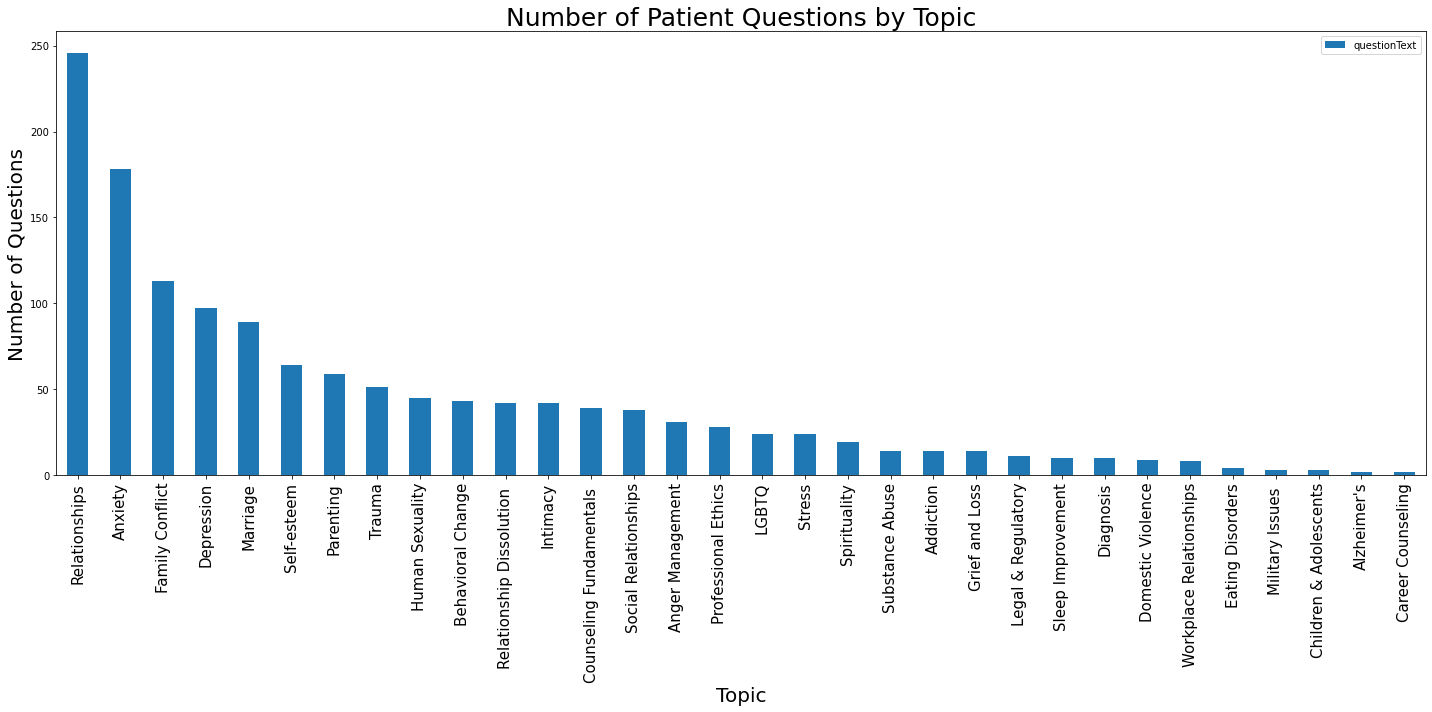

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
counseldf.groupby('topics').agg('count').sort_values('questionText', ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Patient Questions by Topic", fontsize=25)
ax.set_ylabel("Number of Questions", fontsize=20)
ax.set_xlabel("Topic", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
plt.tight_layout()
plt.show()

After this initial analysis to look at the overall dataset, the 'topics' column could be one-hot encoded so that it is ready for the learning model to take as targets.

In [17]:
targetdf = pd.get_dummies(counseldf['topics'])
targetdf

,Addiction,Alzheimer's,Anger Management,Anxiety,Behavioral Change,Career Counseling,Children & Adolescents,Counseling Fundamentals,Depression,Diagnosis,Domestic Violence,Eating Disorders,Family Conflict,Grief and Loss,Human Sexuality,Intimacy,LGBTQ,Legal & Regulatory,Marriage,Military Issues,Parenting,Professional Ethics,Relationship Dissolution,Relationships,Self-esteem,Sleep Improvement,Social Relationships,Spirituality,Stress,Substance Abuse,Trauma,Workplace Relationships
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Now, finally it is time to apply natural language processing techniques to each of the individual text samples.

First, we define a pre-process function.

In [18]:
#Preprocess function


import nltk, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

stop_words = stopwords.words('english')
normalizer = WordNetLemmatizer()

def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

def preprocess_text(text):
    cleaned = re.sub(r'\W+', ' ', text).lower()
    tokenized = word_tokenize(cleaned)
    normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    return normalized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
counseldf['questionText'][13]

'I have a lot of issues going on right now. First of all, I have a lot of trouble sleeping at times, while other nights I sleep too much and still feel quite tired. I’m also noticing increased irritability and experiencing anxiety attacks that last for hours. Is there something wrong with me and if so what should I do?'

In [20]:
text = counseldf['questionText'][13]
cleaned = re.sub(r'\W+', ' ', text).lower()
print(cleaned)

i have a lot of issues going on right now first of all i have a lot of trouble sleeping at times while other nights i sleep too much and still feel quite tired i m also noticing increased irritability and experiencing anxiety attacks that last for hours is there something wrong with me and if so what should i do 


In [21]:
tokenized = word_tokenize(cleaned)
print(tokenized)

['i', 'have', 'a', 'lot', 'of', 'issues', 'going', 'on', 'right', 'now', 'first', 'of', 'all', 'i', 'have', 'a', 'lot', 'of', 'trouble', 'sleeping', 'at', 'times', 'while', 'other', 'nights', 'i', 'sleep', 'too', 'much', 'and', 'still', 'feel', 'quite', 'tired', 'i', 'm', 'also', 'noticing', 'increased', 'irritability', 'and', 'experiencing', 'anxiety', 'attacks', 'that', 'last', 'for', 'hours', 'is', 'there', 'something', 'wrong', 'with', 'me', 'and', 'if', 'so', 'what', 'should', 'i', 'do']


In [22]:
normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
print(normalized)

['i', 'have', 'a', 'lot', 'of', 'issue', 'go', 'on', 'right', 'now', 'first', 'of', 'all', 'i', 'have', 'a', 'lot', 'of', 'trouble', 'sleeping', 'at', 'time', 'while', 'other', 'night', 'i', 'sleep', 'too', 'much', 'and', 'still', 'feel', 'quite', 'tire', 'i', 'm', 'also', 'notice', 'increase', 'irritability', 'and', 'experience', 'anxiety', 'attack', 'that', 'last', 'for', 'hour', 'be', 'there', 'something', 'wrong', 'with', 'me', 'and', 'if', 'so', 'what', 'should', 'i', 'do']


In [23]:
processed_questionText = counseldf['questionText'].apply(lambda x: preprocess_text(x))


In [24]:
stop_words = set(stopwords.words('english'))

questionText_nostops = []
for title in processed_questionText:
    text_no_stops = [word for word in title if word not in stop_words]
    questionText_nostops.append(text_no_stops)

In [25]:
print(questionText_nostops[13])

['lot', 'issue', 'go', 'right', 'first', 'lot', 'trouble', 'sleeping', 'time', 'night', 'sleep', 'much', 'still', 'feel', 'quite', 'tire', 'also', 'notice', 'increase', 'irritability', 'experience', 'anxiety', 'attack', 'last', 'hour', 'something', 'wrong']


In [26]:
print(questionText_nostops[13])

['lot', 'issue', 'go', 'right', 'first', 'lot', 'trouble', 'sleeping', 'time', 'night', 'sleep', 'much', 'still', 'feel', 'quite', 'tire', 'also', 'notice', 'increase', 'irritability', 'experience', 'anxiety', 'attack', 'last', 'hour', 'something', 'wrong']


In [27]:
import tensorflow as tf
from tensorflow.keras import preprocessing

tf.random.set_seed(4)
tf.__version__

'2.0.0'

In [28]:
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questionText_nostops ) 
tokenized_questions = tokenizer.texts_to_sequences( questionText_nostops ) 
print('Sample tokenized: {}'.format(tokenized_questions[0]))
print('==================================================================================================================\n')

length_list = list()
for token_seq in tokenized_questions:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Questions max length is {} words'.format( max_input_length ))
print('==================================================================================================================\n')

padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=max_input_length , padding='post' )
input_data = np.array( padded_questions )
print( 'Input data shape -> {}\n'.format( input_data.shape ))
print('Input data sample->\n {}'.format(input_data[0]))
print('==================================================================================================================\n')

question_word_dict = tokenizer.word_index
num_question_tokens = len( question_word_dict )+1
print( 'Number of Question tokens = {}\n'.format( num_question_tokens))
print('Dictionary: {}'.format(question_word_dict))

Sample tokenized: [68, 101, 1760, 971, 49, 858, 972, 684, 68, 52, 477, 101, 1761, 101, 52, 477, 68, 859, 165, 1386, 150, 9, 216, 68, 18, 41, 166, 971, 1762, 353, 626, 971]

Questions max length is 220 words

Input data shape -> (1376, 220)

Input data sample->
 [  68  101 1760  971   49  858  972  684   68   52  477  101 1761  101
   52  477   68  859  165 1386  150    9  216   68   18   41  166  971
 1762  353  626  971    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(input_data, targetdf, test_size = 0.3, random_state=2)


In [31]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(963, 220) (413, 220)
(963, 32) (413, 32)


In [32]:
inputs = tf.keras.layers.Input(shape=(None,))
embedding = tf.keras.layers.Embedding(num_question_tokens, 200, mask_zero=True)(inputs)
lstm_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_state=False), name='bidir') (embedding)
dense_outputs = tf.keras.layers.Dense(500, activation=tf.keras.activations.relu) (lstm_outputs)
outputs = tf.keras.layers.Dense(32, activation=tf.keras.activations.softmax) (dense_outputs)

LSTM_model = tf.keras.models.Model(inputs, outputs)
LSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [33]:
LSTM_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 200)         483400    
_________________________________________________________________
bidir (Bidirectional)        (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 500)               100500    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16032     
Total params: 840,732
Trainable params: 840,732
Non-trainable params: 0
_________________________________________________________________


In [34]:
history="/content/drive/MyDrive/NLP/J component/Final_LSTM_model.h5"

In [35]:
LSTM_model.save('/content/drive/MyDrive/NLP/J component/Final_LSTM_model.h5')


In [36]:
def predict(text):
    processed = preprocess_text(text)
    text_no_stops = [word for word in processed if word not in stop_words]
    tokenized = tokenizer.texts_to_sequences( text_no_stops )
    padded = preprocessing.sequence.pad_sequences( tokenized , maxlen=max_input_length , padding='post' )
    input_data = np.array( padded )
    output = LSTM_model.predict(input_data)
    index = np.argmax(output[0])
    print(targetdf.columns[index])

In [37]:
predict(''''I fight with my husband everyday. We cannot seem to agree on anything.
        The marriage is failing and I need to now do a divorce. This has affected my mentally.
        I cannot stop but think about all the memories we had and I was about to loose everything that mattered.''')

Counseling Fundamentals 


In [38]:
newdf = counseldf

In [39]:
newdf.topics = pd.Categorical(newdf.topics)
newdf['target'] = newdf.topics.cat.codes

In [40]:
msk = np.random.rand(len(newdf)) < 0.8

train_df = newdf[msk]

test_df = newdf[~msk]

In [41]:
train_df.head()

,questionText,topics,target
0,My wife and mother are having tense disagreeme...,Family Conflict,12
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse,29
2,"I have secrets in my mind, and I don't know wh...",Family Conflict,12
3,I am extremely possessive in my relationships ...,Behavioral Change,4
4,I had a head injury a few years ago and my min...,Anxiety,3


In [42]:
test_df.head()

,questionText,topics,target
13,I have a lot of issues going on right now. Fir...,Anxiety,3
25,I am going through a divorce from a narcissist...,Domestic Violence,10
33,"I have been with a guy for 4 years, he's a gr...",Relationships,23
34,My boyfriend can't get over my promiscuous pas...,Relationships,23
49,Or how to send him somewhere that can help him...,Substance Abuse,29


In [43]:
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

import tensorflow_hub as hub
import tensorflow as tf
from bert import tokenization
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

In [44]:
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

#Loding pretrained bert layer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)


# Loading tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [45]:
# function to encode the text into tokens, masks, and segment flags
import numpy as np
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

MAX_LEN = 220

# encode train set 
train_input = bert_encode(train_df.questionText.values, bert_tokenizer, max_len=MAX_LEN)
# encode  test set 
test_input = bert_encode(test_df.questionText.values, bert_tokenizer, max_len= MAX_LEN )
train_labels = train_df.target.values

In [46]:
# from tf.keras.utils import to_categorical

categorical_labels = tf.keras.utils.to_categorical(train_labels, num_classes=32)

In [47]:
# first define input for token, mask and segment id  
from tensorflow.keras.layers import  Input
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")

#  output  
from tensorflow.keras.layers import Dense
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])  
clf_output = sequence_output[:, 0, :]
out = Dense(32, activation='sigmoid')(clf_output)   

# intilize model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
BERT_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
BERT_model.compile(Adam(learning_rate=2e-6), loss='categorical_crossentropy', metrics=['accuracy'])
BERT_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 220)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 220)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 220)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [48]:
BERT_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
# train
train_history = BERT_model.fit(
    train_input, categorical_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=128
)

Train on 888 samples, validate on 223 samples
Epoch 1/20
888/888 [==============================] - 1218s 1s/sample - loss: 3.2294 - accuracy: 0.1036 - Recall: 0.7275 - Precision: 0.0546 - val_loss: 3.2371 - val_accuracy: 0.1345 - val_Recall: 0.6054 - val_Precision: 0.0562
Epoch 2/20
888/888 [==============================] - 1177s 1s/sample - loss: 2.9522 - accuracy: 0.1971 - Recall: 0.7545 - Precision: 0.0816 - val_loss: 3.1508 - val_accuracy: 0.1345 - val_Recall: 0.5785 - val_Precision: 0.0690
Epoch 3/20
888/888 [==============================] - 1172s 1s/sample - loss: 2.8146 - accuracy: 0.2038 - Recall: 0.6757 - Precision: 0.1000 - val_loss: 3.0687 - val_accuracy: 0.1345 - val_Recall: 0.4843 - val_Precision: 0.0929
Epoch 4/20
888/888 [==============================] - 1191s 1s/sample - loss: 2.7153 - accuracy: 0.2106 - Recall: 0.5653 - Precision: 0.1151 - val_loss: 2.9727 - val_accuracy: 0.1345 - val_Recall: 0.4753 - val_Precision: 0.1140
Epoch 5/20
888/888 [======================

In [ ]:
BERT_model.save('BERT_model.h5')

In [ ]:
train_history_df = pd.DataFrame(train_history.history)
train_history_df['f1_score'] = (2 * train_history_df['precision']*train_history_df['recall'])/(train_history_df['precision']+train_history_df['recall'])
train_history_df['val_f1_score'] = (2 * train_history_df['val_precision']*train_history_df['val_recall'])/(train_history_df['val_precision']+train_history_

In [ ]:
history_df.head(30)

In [ ]:
plt.plot(train_history.history['loss'], label='training data')
plt.plot(train_history.history['val_loss'], label='validation data')
plt.title('Categorical Crossentropy Loss Plot')
plt.ylabel('loss value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.subplots(figsize=(15,10))
ax = plt.subplot(2,2,1)
plt.plot(train_history.history['accuracy'], label='training_accuracy')
plt.plot(train_history.history['val_accuracy'], label='test_accuracy')
plt.title('Accuracy Plot')
plt.ylabel('accuracy value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,2)
plt.plot(train_history.history['precision'], label='training_precision')
plt.plot(train_history.history['val_precision'], label='test_precision')
plt.title('Precision Plot')
plt.ylabel('precision value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,3)
plt.plot(train_history.history['recall'], label='training_recall')
plt.plot(train_history.history['val_recall'], label='test_recall')
plt.title('Recall Plot')
plt.ylabel('recall value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,4)
plt.plot(train_history_df['f1_score'], label='training_f1')
plt.plot(train_history_df['val_f1_score'], label='test_f1')
plt.title('F1 Score Plot')
plt.ylabel('f1 score value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,))
embedding = tf.keras.layers.Embedding(num_question_tokens, 200, mask_zero=True)(inputs)
lstm_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_state=False), name='bidir') (embedding)
dense_outputs = tf.keras.layers.Dense(500, activation=tf.keras.activations.relu) (lstm_outputs)
outputs = tf.keras.layers.Dense(32, activation=tf.keras.activations.softmax) (dense_outputs)

final_model = tf.keras.models.Model(inputs, outputs)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])